<a href="https://colab.research.google.com/github/rajagopalmotivate1/NeuralDefense/blob/master/attack_cnn_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attacking a CNN

In this exercise we will train a CNN to distinguish between instances of handwritten `0` and instances of handwritten `1`. We will be using `keras` to do this.  

Once we have a trained classifier, we will be using `cleverhans` to create adversarial examples.

In [1]:
!pip install cleverhans

    100% |████████████████████████████████| 204kB 24.7MB/s 
    100% |████████████████████████████████| 51kB 18.3MB/s 


In [2]:
import warnings
import numpy as np
import os
with warnings.catch_warnings():
    import keras # keras is still using some deprectade code
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import BasicIterativeMethod, FastGradientMethod, CarliniWagnerL2
%matplotlib inline 
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


The MNIST dataset contains data for all of the digits, but for now we are only interested in 1s and 0s. Therefore we are extracting only those from the dataset. 

We also need to normalize the data. This means that whatever interval was previously covered by the input values will be squashed to `[0,1]`

In [0]:
def exract_ones_and_zeroes( data, labels ):
    data_zeroes = data[ np.argwhere( labels == 0 ).reshape( -1 ) ][ :9900 ]
    print( data_zeroes.shape )
    data_ones = data[ np.argwhere( labels == 1 ).reshape( -1 ) ][ :2000 ]
    x = np.vstack( (data_zeroes, data_ones) )

    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

Load the actual data and use our preprocessing function from earlier.

In [4]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()




11493376/11490434 [==============================] - 0s 0us/step
(5923, 28, 28)
(980, 28, 28)


Keras expects the image to have a color channel. We need to add another dimension to our image to represent
that color channel.

In [0]:
# we need to bring the data in to a format that our cnn likes
y_train = keras.utils.to_categorical( y_train, 2 )
y_test = keras.utils.to_categorical( y_test, 2 )

if keras.backend.image_data_format( ) == 'channels_first':
    x_train = x_train.reshape( x_train.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    x_test = x_test.reshape( x_test.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    input_shape = (1, x_train.shape[ 1 ], x_train.shape[ 2 ])
else:
    x_train = x_train.reshape( x_train.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
    x_test = x_test.reshape( x_test.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
    input_shape = (x_train.shape[ 1 ], x_train.shape[ 2 ], 1)



We need to make sure that `cleverhans` has access to our model graph. To do this we make sure that `keras` uses the same `tensorflow` session that `cleverhans` will be using. 

In [0]:
# need to some setup so everything gets excecuted in the same tensorflow session
session = tf.Session( )
keras.backend.set_session( session )

In [0]:
def createNetwork1():
  clf = keras.Sequential( )
  clf.add( Conv2D( 32, kernel_size=(3, 3), activation='relu', input_shape=input_shape ) )
  clf.add( Conv2D( 64, (3, 3), activation='relu' ) )
  clf.add( MaxPooling2D( pool_size=(2, 2) ) )
  clf.add( Dropout( 0.25 ) )
  clf.add( Flatten( ) )
  clf.add( Dense( 128, activation='relu' ) )
  clf.add( Dropout( 0.5 ) )
  clf.add( Dense( 2, activation='softmax' ) )
  return clf

In [0]:
def createNetwork2():
  clf = keras.Sequential( )
  clf.add( Conv2D( 32, kernel_size=(3, 3), activation='relu', input_shape=input_shape ) )
  clf.add( Conv2D( 64, (3, 3), activation='relu' ) )
  clf.add( MaxPooling2D( pool_size=(2, 2) ) )
  clf.add( Conv2D( 128, (3, 3), activation='relu' ) )  
  clf.add( Dropout( 0.25 ) )
  clf.add( Flatten( ) )
  clf.add( Dense( 128, activation='relu' ) )
  clf.add( Dropout( 0.5 ) )
  clf.add( Dense( 2, activation='softmax' ) )
  return clf

We are using a very simple CNN. For our two output classes this is probably overkill. This network can be used to distinguish between all 10 classes with very high accuracy.

In [0]:
clf = createNetwork2()

In [14]:
# define the classifier


clf.compile( loss=keras.losses.categorical_crossentropy,
             optimizer='adam',
             metrics=[ 'accuracy' ] )

clf.fit( x_train, y_train,
         epochs=2,
         verbose=1 )
#clf.summary( )
score = clf.evaluate( x_test, y_test, verbose=0 )
print( 'Test loss:', score[ 0 ] )
print( 'Test accuracy:', score[ 1 ] )


Epoch 1/2
7923/7923 [==============================] - 36s 5ms/step - loss: 0.0183 - acc: 0.9903
Epoch 2/2
7923/7923 [==============================] - 35s 4ms/step - loss: 0.0064 - acc: 0.9984
Test loss: 0.0007034933704338247
Test accuracy: 0.9995271867612293


Let's get to the actual attack magic. First we are picking a sample that we want to perturbate. After selecting the sample, we will use the FGSM attack and the Carlini & Wagner L2 attack to perturbate it into an adversarial example.

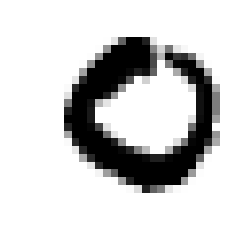

[INFO 2019-03-13 04:45:50,024 cleverhans] Constructing new graph for attack FastGradientMethod


class prediction for the test samples: [[1.0000000e+00 3.1510532e-09]]
[[1. 0.]]
[[1. 0.]]
class prediction for the modified test samples: [[0.13517022 0.8648297 ]]
[[0.14 0.86]]
[[0. 1.]]


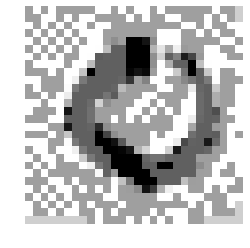

In [15]:
#chose a sample to pertubate
sample_ind = 103

# picking a test sample
sample = x_test[ sample_ind, : ]


# plot the first instance in the traning set
plt.imshow( sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

# constructing adversarial examples
print( 'class prediction for the test samples:',
       clf.predict( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) ) )

prediction1 = clf.predict( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) )

print ( np.round(prediction1 , 2 ) )

print ( np.round(prediction1) )


# setup the attack
wrapper = KerasModelWrapper( clf )
fgm = FastGradientMethod( wrapper, sess=session )
eps = 0.3 # allowed maximum modification

# excetute the attack
with warnings.catch_warnings():
    modified_sample = fgm.generate_np( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ),
                                   **{ 'eps': eps } )

print( 'class prediction for the modified test samples:',
       clf.predict( modified_sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) ) )

predictiononmodifiedsample = clf.predict( modified_sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) )


print ( np.round(predictiononmodifiedsample , 2 ) )

print ( np.round(predictiononmodifiedsample) )

plt.imshow( modified_sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )


[INFO 2019-03-13 04:45:50,475 cleverhans] Constructing new graph for attack CarliniWagnerL2
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


class prediction for the cw modified test samples: [[0.4968387  0.50316125]]


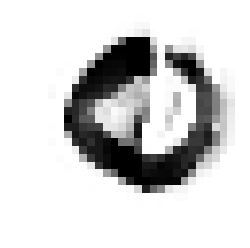

In [16]:

# let's try a stronger attack
with warnings.catch_warnings():
    cw_l2 = CarliniWagnerL2( wrapper, sess=session )
    modified_sample = cw_l2.generate_np( sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) )

print( 'class prediction for the cw modified test samples:',
       clf.predict( modified_sample.reshape( (1, sample.shape[ 0 ], sample.shape[ 1 ], sample.shape[ 2 ]) ) ) )
plt.imshow( modified_sample.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )
